In [2]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from data_sim import gen_timeseries
import matplotlib as mpl
import time
from matplotlib import interactive

In [3]:
mpl.rcParams['agg.path.chunksize'] = 100_000

LOWCUT = 34_500
HIGHCUT = 35_500
PING_FREQ = 35_000
BANDPASS_WIDTHS = [4_000, 2_000, 1000, 750, 500]
BANDPASS_WIDTH = 1000
LOWPASS_CUTOFF = 6_000 # kinda arbitrarily chosen. In practice, cutoff for envelope detection should be square root of carrier freq (35 kHz) and message freq (not quite sure, chose 1 kHz?) TODO: Run fft on data and see what the frequency spectrum looks like

SAMPLE_RATE = 625_000

## Filter Functions

In [4]:
def butter_bandpass(lowcut, highcut, fs=SAMPLE_RATE, order=5):
    """
    Generates the coefficients for a Butterworth bandpass filter.

    Parameters
    ----------
    lowcut : int
        The lower frequency cutoff

    highcut : int
        The higher frequency cutoff

    fs : int
        The sample rate

    order : int
        The order of the filter

    Returns
    -------
    b : np.array
        The numerator coefficients

    a : np.array
        The denominator coefficients
    """

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a


In [5]:
def butter_bandpass_filter(data, lowcut=LOWCUT, highcut=HIGHCUT, fs=SAMPLE_RATE, order=5):
    """
    Filters the data using a Butterworth bandpass filter.
    
    Parameters
    ----------
    data : np.array
        The data to be filtered
        
    lowcut : int
        The lower frequency cutoff
    
    highcut : int
        The higher frequency cutoff
    
    fs : int
        The sample rate
    
    order : int
        The order of the filter
    """

    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
def butter_lowpass_filter(data, cutoff=LOWPASS_CUTOFF, fs = SAMPLE_RATE, order = 5):
    """
    Filters the data using a Butterworth bandpass filter.
    
    Parameters
    ----------
    data : np.array
        The data to be filtered
        
    cutoff : int
        The cutoff frequency of the filter
    
    fs : int
        The sample rate
    
    order : int
        The order of the filter
    """

    nyquist = 0.5 * fs
    cut = cutoff / nyquist
    b, a = butter(order, cut, btype='low')
    y = lfilter(b,a,data)
    return y

In [7]:
# Filter and detect peaks for each channel
def detect_wave_packet(channel_data):
    """
    Detects the peaks in a channel's data and returns the peak indices and the filtered signal.

    Parameters
    ----------
    channel_data : np.array
        The channel's data

    Returns
    -------
    peaks : np.array
        The peak indices

    filtered_signal : np.array
        The filtered signal
    """

    # Filter the channel data
    filtered_signal = butter_bandpass_filter(channel_data)

    # Find peaks in the filtered signal
    peaks, _ = find_peaks(filtered_signal, height=0.01, distance=100)

    return peaks, filtered_signal

## Experimentation

In [8]:
DATA = np.genfromtxt('sample1.csv', delimiter=',', skip_header=1)
RECTIFIED = np.absolute(DATA[:,1])
CHANNELS = [np.absolute(DATA[:,i+1]) for i in range(3)]

In [9]:
data_cutoff = 1_000_000

In [11]:
r1 = butter_bandpass_filter(RECTIFIED, 50000, 58000)[data_cutoff:]
# r2 = butter_bandpass_filter(RECTIFIED, 25000, 40000)[data_cutoff:]

plt.plot(r1)
# plt.plot(r2)
plt.legend(['r1'])
plt.plot()

2024-01-11 21:46:03.304 Python[8748:189757] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/bw/4tzf4sn540g21cjq2sgsty4w0000gn/T/org.python.python.savedState


[]

: 

0 done, 0.19584920899978897 ms elapsed
1 done, 0.3679415419992438 ms elapsed
2 done, 0.5303892499996437 ms elapsed
3 done, 0.6947921669998323 ms elapsed
4 done, 0.8595583749993239 ms elapsed
5 done, 1.0656995839999581 ms elapsed
6 done, 1.2348209589999897 ms elapsed
[14911826, 14911826, 14911826, 14911826, 14911826, 14911826, 14911826, 14911826]


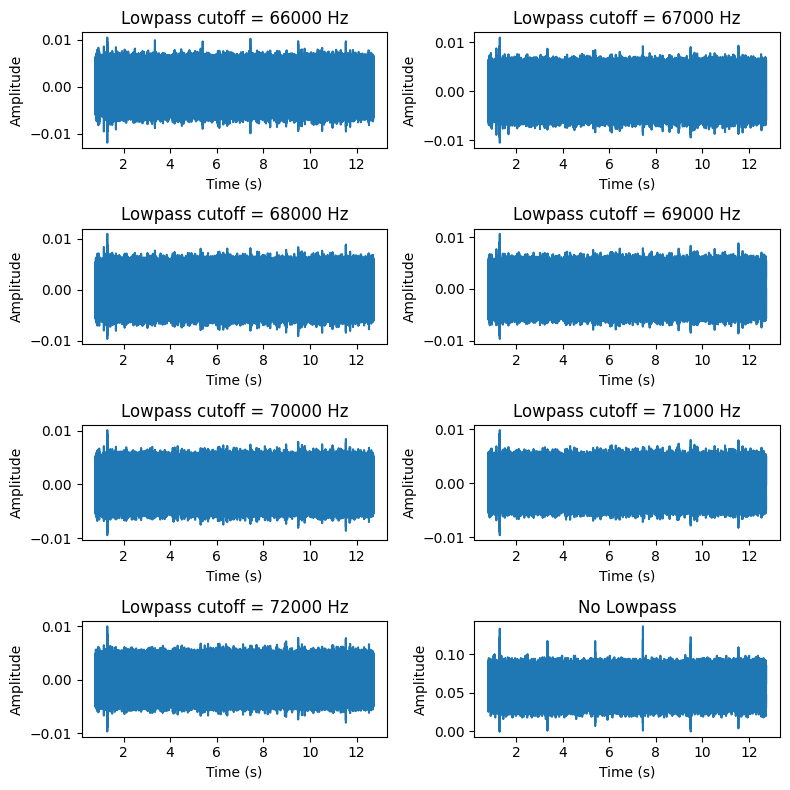

In [32]:
filtered_signals = []
freqs = []
start = time.perf_counter()

for i in range(7):
    # filtered_signal = butter_bandpass_filter(rectified, PING_FREQ -  BANDPASS_WIDTH/2, PING_FREQ + BANDPASS_WIDTH/2)
    f = (i+60)*1000
    freqs.append(f)
    # filtered_signal = butter_lowpass_filter(RECTIFIED, LOWPASS_CUTOFF + f)
    filtered_signal = butter_bandpass_filter(RECTIFIED, f, 100_000)
    filtered_signals.append(filtered_signal[data_cutoff:])
    print(f"{i} done, {time.perf_counter() - start} ms elapsed")
    

filtered_signals.append(RECTIFIED[data_cutoff:])
freqs.append(float('inf'))

print([len(filtered_signals[i]) for i in range(len(filtered_signals))])

_, ax = plt.subplots(4,2, figsize=(8,8))

for i in range(len(filtered_signals)):
    # Plot the detected peaksx
    #ax[i,1].plot(data_0[peaks[i],0], filtered_signals[i][peaks[i]], "x")
    ax[i//2,i%2].plot(DATA[data_cutoff:,0], filtered_signals[i])
    ax[i//2,i%2].set_title(f"Lowpass cutoff = {LOWPASS_CUTOFF + freqs[i]} Hz")
    ax[i//2,i%2].set_xlabel("Time (s)")
    ax[i//2,i%2].set_ylabel("Amplitude")
    # ax[i,1].set_yscale("log")
    # ax[i,1].set_ylim(-100,100)

ax[i//2,i%2].set_title("No Lowpass")
plt.tight_layout()
plt.show()